In [1]:
import numpy as np
import pandas as pd
import tqdm
from scipy import signal
from pathlib import Path

from dataset_processor import (
    CalcTimeDiffMean,
    PlotDiffMean,
    Resampler,
    Windowize,
    AddStandardActivityCode,
    Pipeline
)

In [2]:
def read_kuhar(kuhar_dir_path):
    kuhar_dir_path = Path(kuhar_dir_path)

    # Cria um dicionário com os tipos de dados de cada coluna
    feature_dtypes = {
        "accel-start-time": np.float32,
        "accel-x": np.float32,
        "accel-y": np.float32,
        "accel-z": np.float32,
        "gyro-start-time": np.float32,
        "gyro-x": np.float32,
        "gyro-y": np.float32,
        "gyro-z": np.float32,
    }

    dfs = []
    for i, f in enumerate(sorted(kuhar_dir_path.rglob("*.csv"))):
        # Pega o nome da atividade (nome da pasta, ex.: 5.Lay)
        # Pega o nome do arquivo CSV (ex.: 1052_F_1.csv)
        # Separa o número da atividade e o nome (ex.: [5, 'Lay'])
        activity_no, activity_name = f.parents[0].name.split(".")
        activity_no = int(activity_no)

        # Divide o código do usuário, o tipo de atividade e o número de serial (ex.: [1055, 'G', 1])
        csv_splitted = f.stem.split("_")
        user = int(csv_splitted[0])
        serial = "_".join(csv_splitted[2:])

        # Le o arquivo CSV
        df = pd.read_csv(f, names=list(feature_dtypes.keys()), dtype=feature_dtypes)
        # Apenas reordenando as colunas (não é removida nenhuma coluna)
        df = df[
            [
                "accel-x",
                "accel-y",
                "accel-z",
                "gyro-x",
                "gyro-y",
                "gyro-z",
                "accel-start-time",
                "gyro-start-time",
            ]
        ]

        # ----- Adiciona colunas auxiliares e meta-dados ------
        # Como é um simples instante de tempo (sem duração), o tempo de início e fim são iguais
        df["accel-end-time"] = df["accel-start-time"]
        df["gyro-end-time"] = df["gyro-start-time"]
        # Adiciona a coluna com o código da atividade
        df["activity code"] = activity_no
        # Adiciona a coluna do índice (qual é o numero da linha da amostra no dataframe)
        df["index"] = range(len(df))
        # Adiciona a coluna do usuário
        df["user"] = user
        # Adiciona a coluna do serial (a vez que o usuário praticou)
        df["serial"] = serial
        # Adiciona a coluna com o caminho do csv
        df["csv"] = "/".join(f.parts[-2:])
        # ----------------------------------------------------
        dfs.append(df)
    return pd.concat(dfs)


def users(df):
    return np.sort(df["user"].unique()).tolist()


def activities(df):
    return np.sort(df["activity code"].unique()).tolist()


In [3]:
kuhar_path = "data/raw/KuHar/1.Raw_time_domian_data"

feature_columns = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z",
]

column_group = "csv"

# activity code: standard activity code
standard_activity_code_map = {
    0: 1,
    1: 0,
    2: -1,
    3: -1,
    4: -1,
    5: -1,
    6: -1,
    7: -1,
    8: -1,
    9: -1,
    10: -1,
    11: 2,
    12: -1,
    13: -1,
    14: 5,
    15: 3,
    16: 4,
    17: -1,
}


## Bruto

Executing CalcTimeDiffMean
Executing PlotDiffMean


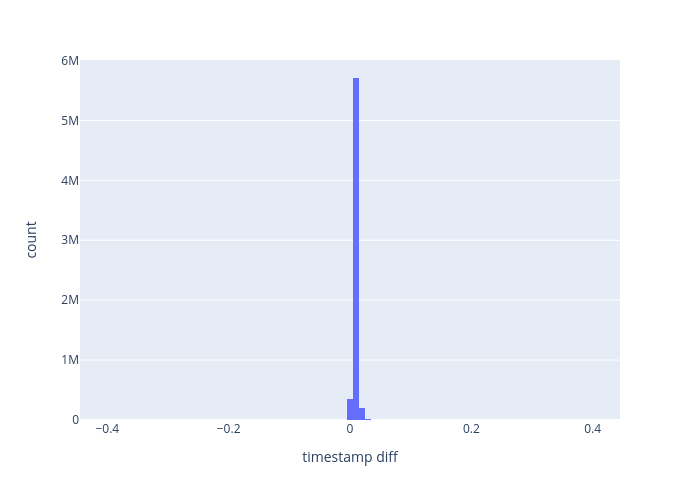

Executing Windowize


Creating windows: 100%|██████████| 1939/1939 [02:34<00:00, 12.58it/s]


Executing AddStandardActivityCode


,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,timestamp diff,activity code,csv,gyro-end-time,serial,accel-start-time,gyro-start-time,user,index,standard activity code
0,-0.00028,-0.013218,-0.006041,0.019178,0.056363,0.05167,0.066037,0.084075,0.053171,0.031872,...,0.01,0.0,0.Stand/1001_A_1.csv,0.014,1,0.013,0.014,1001,1,1
1,0.065882,0.070706,0.079351,0.045129,-0.00106,-0.01858,-0.026813,-0.01128,-0.00422,-0.006679,...,0.009,0.0,0.Stand/1001_A_1.csv,3.023,1,3.022,3.023,1001,301,1
2,0.06039,0.05483,0.026566,-0.007787,-0.023151,-0.030435,0.002795,0.008467,0.009453,0.005837,...,0.01,0.0,0.Stand/1001_A_1.csv,6.023,1,6.022,6.023,1001,601,1
3,0.106681,0.109868,0.097632,0.062969,0.021348,-0.008206,-0.038906,-0.051849,-0.044724,0.006483,...,0.01,0.0,0.Stand/1001_A_1.csv,9.023,1,9.021,9.023,1001,901,1
4,-0.010397,0.005637,0.043228,0.04267,0.045788,0.046685,0.027399,0.022593,0.009374,0.004614,...,0.01,0.0,0.Stand/1001_A_1.csv,12.033,1,12.022,12.033,1001,1201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19931,-1.060055,-1.347055,-1.679445,-1.832445,-1.774445,-1.519322,-1.308322,-1.116323,-1.018729,-0.980729,...,0.001,9.0,9.Push-up/1101_J_9.csv,4.775,9,4.774,4.775,1101,601,-1
19932,0.01636,0.05436,-0.058792,0.018208,0.152208,0.213362,0.922362,0.596362,0.918972,1.052973,...,0.002,9.0,9.Push-up/1101_J_9.csv,7.147,9,7.149,7.147,1101,901,-1
19933,-1.337867,-1.356867,-1.24146,-1.12646,-1.01146,-0.802776,-0.611776,-0.362776,-0.184689,-0.069689,...,0.006,9.0,9.Push-up/1101_J_9.csv,9.525,9,9.53,9.525,1101,1201,-1
19934,-2.447437,-2.007437,-1.898934,-2.339934,-2.817934,-2.881031,-2.881031,-2.747031,-1.821934,-0.768934,...,0.0,9.0,9.Push-up/1101_J_9.csv,11.904,9,11.904,11.904,1101,1501,-1


In [4]:
dataframe = read_kuhar(kuhar_path)

differ = CalcTimeDiffMean(
    groupby_column=column_group,
    column_to_diff="accel-start-time",
    new_column_name="timestamp diff",
    filter_predicate=lambda x: (
        (x["timestamp diff"] < 1) & (x["timestamp diff"] > -1.0)
    ).all()
)

plotter = PlotDiffMean(column_to_plot="timestamp diff")

windowizer = Windowize(
    features_to_select=feature_columns,
    samples_per_window=300,
    samples_per_overlap=0,
    groupby_column="csv",
)

standard_label_adder = AddStandardActivityCode(standard_activity_code_map)

pipeline = Pipeline(
    [
        differ,
        plotter,
        windowizer,
        standard_label_adder
    ]
)

new_df = pipeline(dataframe)
new_df

### Normatizado

In [5]:
dataframe = read_kuhar(kuhar_path)

differ = CalcTimeDiffMean(
    groupby_column=column_group,
    column_to_diff="accel-start-time",
    new_column_name="timestamp diff",
    filter_predicate=lambda x: (
        (x["timestamp diff"] < 1) & (x["timestamp diff"] > -1.0)
    ).all()
)

resampler = Resampler(
    groupby_column=column_group,
    features_to_select=feature_columns,
    original_fs=100,
    target_fs=20,
)

windowizer = Windowize(
    features_to_select=feature_columns,
    samples_per_window=60,
    samples_per_overlap=0,
    groupby_column="csv",
)

standard_label_adder = AddStandardActivityCode(standard_activity_code_map)

pipeline = Pipeline(
    [
        differ,
        resampler,
        windowizer,
        standard_label_adder
    ]
)

new_df_normalized = pipeline(dataframe)
new_df_normalized

Executing CalcTimeDiffMean
Executing Resampler


Resampling: 100%|██████████| 1939/1939 [00:10<00:00, 184.54it/s]


Executing Windowize


Creating windows: 100%|██████████| 1938/1938 [02:00<00:00, 16.13it/s]


Executing AddStandardActivityCode


,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,activity code,csv,gyro-end-time,level_0,serial,accel-start-time,gyro-start-time,user,index,standard activity code
0,0.043221,0.035365,0.037141,-0.016584,0.054805,0.008676,0.016168,0.000466,0.026772,0.025546,...,0.0,0.Stand/1001_A_1.csv,0.014,0,1,0.013,0.014,1001,1,1
1,0.077065,-0.021952,0.027853,-0.019742,0.016611,0.041058,-0.008755,0.029699,-0.005005,0.005171,...,0.0,0.Stand/1001_A_1.csv,0.614,60,1,0.612,0.614,1001,61,1
2,0.035829,-0.019009,0.055176,-0.006932,0.008262,0.043238,-0.022822,0.040555,-0.008272,0.039646,...,0.0,0.Stand/1001_A_1.csv,1.214,120,1,1.212,1.214,1001,121,1
3,0.106844,-0.02708,0.044087,0.035789,0.013372,0.071647,-0.034341,0.067457,0.01713,0.019128,...,0.0,0.Stand/1001_A_1.csv,1.813,180,1,1.812,1.813,1001,181,1
4,-0.008002,0.052367,-0.024825,0.05931,-0.021451,0.029315,0.018877,0.013788,0.027899,-0.028402,...,0.0,0.Stand/1001_A_1.csv,2.424,240,1,2.412,2.424,1001,241,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900,-4.569679,-3.302958,-1.807048,-1.127767,-0.583351,1.138263,0.435411,1.454923,1.020441,1.38131,...,9.0,9.Push-up/1101_J_9.csv,0.966,6276699,9,0.966,0.966,1101,121,-1
19901,-1.623317,-1.524496,-1.489689,-0.605521,-0.849977,-0.551365,-0.756675,-1.365537,-1.90372,-2.877717,...,9.0,9.Push-up/1101_J_9.csv,1.441,6276759,9,1.442,1.441,1101,181,-1
19902,-2.506349,-2.027242,-0.94517,-0.812147,-0.635925,1.031951,1.024809,1.389969,1.180898,1.319687,...,9.0,9.Push-up/1101_J_9.csv,1.917,6276819,9,1.917,1.917,1101,241,-1
19903,-0.210449,0.861534,-0.164338,0.660002,0.799019,-1.520216,-1.335855,-1.699263,-1.050786,-0.792002,...,9.0,9.Push-up/1101_J_9.csv,2.392,6276879,9,2.393,2.392,1101,301,-1
